In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import math
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator, colors

Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\ADMIN\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
Directory = r"F:\Work\SOCAAutomation\Dataset\Images\09072024_1_1"
FileName = "2024_07_09_11_30_174.jpg"
raw_img = cv.imread(Directory + "/" + FileName)
img = cv.cvtColor(raw_img, cv.COLOR_BGR2GRAY)
img = raw_img

In [2]:
def resize(frame, width = 640, height = 640):
    return cv.resize(frame, (width, height), interpolation = cv.INTER_LINEAR)
def InferenceImage(model, frame):
    results = model(resize(frame), conf=0.3, save=True, show_labels=False, retina_masks=True)
    return results

# Visibility Estimation

In [2]:
def edge_detection(img):    
    gradx = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=3)
    grady = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=3)
    return gradx, grady

def blurimage(img, kernelsize):
    return cv.GaussianBlur(img, (kernelsize, kernelsize), 0)

def convertgray(img):    
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    return gray

def preprocess(img, kernelsize):
    gray_img = convertgray(img)
    img_blur = blurimage(gray_img, kernelsize)
    gradx, grady = edge_detection(img_blur)
    grad_mag = cv.magnitude(gradx, grady)
    grad_mag_norm = cv.normalize(grad_mag, None, 0, 255, cv.NORM_MINMAX)
    return grad_mag_norm

def count_edges(target_img, kernelsize, multiplier):
    preprocessed_img = preprocess(target_img, kernelsize)
    _, thresh = cv.threshold(preprocessed_img, multiplier * np.median(preprocessed_img), 255, cv.THRESH_BINARY)             
    total_edges = np.count_nonzero(thresh)
    return total_edges

def edge_strength_ratio(ref_edge, target_edge):
    return np.round((target_edge / ref_edge),2)

In [ ]:
gaussian_kernel = 5
multiplier = 5
ref_edge = count_edges(ref_image, kernelsize, multiplier)
curr_edge = count_edges(image, kernelsize, multiplier)
edge_strength = np.round((curr_edge / ref_edge),2)

In [20]:
def calcFrames(start, end, fps, offset=200):
    startFrame = (int(start[0]) * 60 + int(start[1])) * fps
    endFrame = (int(end[0]) * 60 + int(end[1])) * fps 
    return startFrame-offset, endFrame+offset

In [2]:
data = pd.read_csv(r"F:\Work\SOCAAutomation\Dataset\Book1.csv")
data.head()

NameError: name 'pd' is not defined

# Build Features

In [3]:
def MaskStrength(mask, img):
    """
    Calculates Pixel Strength for mask
    1. Apply mask on the original color image
    2. Calculate average of non zero pixels
    """
    mask_3d = np.expand_dims(mask, axis=-1)
    masked_array = (img * mask_3d).flatten()
    return masked_array[masked_array>0].mean().round(2)

def MaskCentroid(mask):
    """
    Calculates Centroid for mask
    1. Extract indices of non zero pixels in a mask
    2. Calculate average of x and y coordinates
    3. Flip the array, since here x and y corresponds to row and column
    """
    mask_indices = np.where(mask)
    mask_centroid = np.round(np.mean(mask_indices, axis=1))
    flip_centroid = list(np.flip(mask_centroid))
    return flip_centroid


In [ ]:
# Define list of features to be extracted from the segmented image
feature_list = ['n_masks', 'mask_area', 'mask_centroid', 'mask_conf', 'mask_strength', 
                'bbox_area', 'bbox_centroid', 'bbox_dim']

features = {key: [] for key in feature_list}

# Check if atleast one mask exist
if results[0].masks is not None:
    # Calculate number of masks in the segmented image
    features['n_masks'] = len(results[0].masks)    
    
    # Bounding Box Parameters
    bboxes = results[0].boxes
    
    # Extract confidence score of all the masks
    features['mask_conf'] = list(np.array(bboxes.conf))
    bbox_data = np.array(bboxes.data)
    
    for box in bbox_data:
        # Extract Bounding box dimension [Width, Height] for each box
        width = np.round(abs(box[0] - box[2]))
        height = np.round(abs(box[1] - box[3]))            
        features['bbox_dim'].append([width, height])
        
        # Extract Bounding box Centroid for each box
        xcoord = np.round(np.mean([box[0], box[2]]))
        ycoord = np.round(np.mean([box[1], box[3]]))
        features['bbox_centroid'].append([xcoord, ycoord])
        
        # Calculate Bounding box Area for each box
        features['bbox_area'].append(width * height)
        
    # Mask Parameters
    masks = np.array(results[0].masks.data, dtype='uint8')
    for mask in masks:
        # Mask Area: Count number of non zero pixels in mask
        features['mask_area'].append(np.count_nonzero(mask))
        
        # Mask Centroid: Calculate mean of non zero pixel x and y coordinates
        features['mask_centroid'].append(MaskCentroid(mask))
        
        ## Mask Strength: 
        # Apply mask on the original image
        # Measure average pixel strength excluding non zero pixels
        features['mask_strength'].append(MaskStrength(mask, test_img_resized))


# Main

In [47]:
# Configurations
model_file = r"F:\Work\SOCAAutomation\Models\11_04_2025\best.pt"
video_file = r"F:\Work\SOCAAutomation\Dataset\Converted\04_07_2024\AXIS 213 - 10.1.5.173 2024-07-04_11_51_08_772.mp4"
data = pd.read_csv(r"F:\Work\SOCAAutomation\Dataset\Book1.csv")
data_grp = data.groupby(['Folder', 'Video File'])[['Start Time', 'End Time']].agg(list)
start_list = data_grp.iloc[0]['Start Time']
end_list = data_grp.iloc[0]['End Time']
fps = 30

In [25]:
print("Start Frame: {} and End Frame {} is recalculated...".format(5,  10))

Start Frame: 5 and End Frame 10 is recalculated...


In [ ]:
# Load Model
# REINSTALL ULTRALYTICS 8.2.103 #model = YOLO(model_file, task='segment')


# Load video
video = cv.VideoCapture(video_file)

# Loop over frames

count_frame = 0
frame_referenced = False
subseg_det = false
subseg_ind = 0
start_frame, end_frame = calcFrames(start_list[subseg_ind].split(":"), end_list[subseg_ind].split(":"), fps):
while True:
    ret, frame = video.read()
    count_frame += 1 
    if ret:               
        if frame_referenced is False and count_frame > 10 and count_frame < 100:
            # Build reference image
            ref_image = resize(frame)
            ref_edge = count_edges(ref_image, kernelsize, multiplier)
            frame_referenced = True
            print("Reference Frame detected and Reference edge is {}".format(ref_edge))
        if count_frame >= start_frame and count_frame <= end_frame:
            subseg_det = True
            print("Subsegment {} is detected...".format(subseg_ind + 1))
            
        elif subseg_det is True:
            subseg_det = False
            ind += 1            
            start_frame, end_frame = calcFrames(start_list[subseg_ind].split(":"), end_list[subseg_ind].split(":"), fps)
            print("Start Frame: {} and End Frame {} is recalculated...".format(start_frame,  end_frame))
    else:
        if subseg_det is True:
            print("{} frame is missing".format(count_frame))
            
        



# Reference Images Visibility: Once for one experiment
# Load Reference image
# Estimate visibility

# Loop over subsegments of video

# Inference image

# Build Features



# Testing

In [94]:
test_img_path = r"F:\Work\SOCAAutomation\Dataset\TestImages\TwoFire.jpg"
model_file = r"F:\Work\SOCAAutomation\Models\11_04_2025\best.pt"
# model_file = r"F:\Work\SOCAAutomation\Models\28_08_2024\best_yolov8m_seg.pt"
model_file = r"F:\Work\SOCAAutomation\Models\08_04_2025\best_yolov8s_seg.pt"
model = YOLO(model_file)#, task='segment')
test_img = cv.imread(test_img_path)
test_img_resized = resize(test_img)

In [95]:
results = model(test_img_resized, conf=0.3, save=True, show_labels=False, retina_masks=True)


0: 640x640 1 Fire-Smoke-Sodium-Tray, 5372.8ms
Speed: 285.3ms preprocess, 5372.8ms inference, 649.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\segment\predict16


In [96]:
results = model.track(source="combine_images.mp4", tracker="botsort.yaml")



WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/150) C:\Users\ADMIN\Documents\pyNotebooks\SodiumDisposal\combine_images.mp4: 640x640 2 Fire-Smoke-Sodium-Trays, 2279.1ms
video 1/1 (frame 2/150) C:\Users\ADMIN\Documents\pyNotebooks\SodiumDisposal\combine_images.mp4: 640x640 2 Fire-Smoke-Sodium-Trays, 1724.6ms
video 1/1 (frame 3/150) C:\Users\ADMIN\Documents\pyNotebooks\SodiumDisposal\combine_images.mp4: 640x640 2 Fire-Smoke-Sodium-Trays, 1691.5ms
video 1/1 (frame 4/150) C:\Users\ADMIN

video 1/1 (frame 56/150) C:\Users\ADMIN\Documents\pyNotebooks\SodiumDisposal\combine_images.mp4: 640x640 3 Fire-Smoke-Sodium-Trays, 1845.7ms
video 1/1 (frame 57/150) C:\Users\ADMIN\Documents\pyNotebooks\SodiumDisposal\combine_images.mp4: 640x640 3 Fire-Smoke-Sodium-Trays, 1687.5ms
video 1/1 (frame 58/150) C:\Users\ADMIN\Documents\pyNotebooks\SodiumDisposal\combine_images.mp4: 640x640 3 Fire-Smoke-Sodium-Trays, 2030.8ms
video 1/1 (frame 59/150) C:\Users\ADMIN\Documents\pyNotebooks\SodiumDisposal\combine_images.mp4: 640x640 3 Fire-Smoke-Sodium-Trays, 2128.9ms
video 1/1 (frame 60/150) C:\Users\ADMIN\Documents\pyNotebooks\SodiumDisposal\combine_images.mp4: 640x640 3 Fire-Smoke-Sodium-Trays, 1940.7ms
video 1/1 (frame 61/150) C:\Users\ADMIN\Documents\pyNotebooks\SodiumDisposal\combine_images.mp4: 640x640 3 Fire-Smoke-Sodium-Trays, 1757.6ms
video 1/1 (frame 62/150) C:\Users\ADMIN\Documents\pyNotebooks\SodiumDisposal\combine_images.mp4: 640x640 2 Fire-Smoke-Sodium-Trays, 1702.5ms
video 1/1 (fr

video 1/1 (frame 115/150) C:\Users\ADMIN\Documents\pyNotebooks\SodiumDisposal\combine_images.mp4: 640x640 1 Fire-Smoke-Sodium-Tray, 1699.5ms
video 1/1 (frame 116/150) C:\Users\ADMIN\Documents\pyNotebooks\SodiumDisposal\combine_images.mp4: 640x640 1 Fire-Smoke-Sodium-Tray, 1747.6ms
video 1/1 (frame 117/150) C:\Users\ADMIN\Documents\pyNotebooks\SodiumDisposal\combine_images.mp4: 640x640 1 Fire-Smoke-Sodium-Tray, 1684.5ms
video 1/1 (frame 118/150) C:\Users\ADMIN\Documents\pyNotebooks\SodiumDisposal\combine_images.mp4: 640x640 2 Fire-Smoke-Sodium-Trays, 1720.5ms
video 1/1 (frame 119/150) C:\Users\ADMIN\Documents\pyNotebooks\SodiumDisposal\combine_images.mp4: 640x640 1 Fire-Smoke-Sodium-Tray, 1807.6ms
video 1/1 (frame 120/150) C:\Users\ADMIN\Documents\pyNotebooks\SodiumDisposal\combine_images.mp4: 640x640 1 Fire-Smoke-Sodium-Tray, 1721.5ms
video 1/1 (frame 121/150) C:\Users\ADMIN\Documents\pyNotebooks\SodiumDisposal\combine_images.mp4: 640x640 1 Fire-Smoke-Sodium-Tray, 2220.0ms
video 1/1 (f

In [81]:
image_folder = r"F:\Work\SOCAAutomation\Dataset\Images\25_04_2025\Source"
files = os.listdir(image_folder)
test_results = []
for i in range(5):
    file_path = image_folder + "/" + files[i]
    results = model.track(file_path, tracker="botsort.yaml")
    test_res.append(results)
    print(len(results))


image 1/1 F:\Work\SOCAAutomation\Dataset\Images\25_04_2025\Source\2024_07_09_11_30_100.jpg: 544x640 2 Fires, 4331.9ms
Speed: 31.0ms preprocess, 4331.9ms inference, 14.0ms postprocess per image at shape (1, 3, 544, 640)
1

image 1/1 F:\Work\SOCAAutomation\Dataset\Images\25_04_2025\Source\2024_07_09_11_30_101.jpg: 544x640 2 Fires, 3473.1ms
Speed: 8.0ms preprocess, 3473.1ms inference, 15.0ms postprocess per image at shape (1, 3, 544, 640)
1

image 1/1 F:\Work\SOCAAutomation\Dataset\Images\25_04_2025\Source\2024_07_09_11_30_102.jpg: 544x640 1 Fire, 3637.3ms
Speed: 13.0ms preprocess, 3637.3ms inference, 26.0ms postprocess per image at shape (1, 3, 544, 640)
1

image 1/1 F:\Work\SOCAAutomation\Dataset\Images\25_04_2025\Source\2024_07_09_11_30_103.jpg: 544x640 1 Fire, 3564.2ms
Speed: 12.0ms preprocess, 3564.2ms inference, 19.0ms postprocess per image at shape (1, 3, 544, 640)
1

image 1/1 F:\Work\SOCAAutomation\Dataset\Images\25_04_2025\Source\2024_07_09_11_30_104.jpg: 544x640 1 Fire, 3350.0

In [97]:
# Extract Tracking results
out_path = r"F:\Work\SOCAAutomation\Dataset\Images\25_04_2025\Output_Model_08_04_2025"
frame = 0
for result in results:
    # Get bounding boxes and tracking IDs
    if result.masks is not None:
        img = result.orig_img
        boxes = result.boxes.xyxy
        track_ids = result.boxes.id

        # Draw the bounding boxes and track IDs on the image
        for box, track_id in zip(boxes, track_ids):
            x1, y1, x2, y2 = map(int, box)
            cv.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv.putText(img, f"ID: {track_id}", (x1, y1 - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        cv.imwrite(out_path + "/" + str(frame) + ".jpg", img)
    frame += 1

TypeError: 'NoneType' object is not iterable

In [98]:
# Define list of features to be extracted from the segmented image
feature_list = ['frame', 'n_masks', 'mask_area', 'mask_centroid', 'mask_conf', 'mask_strength', 
                'bbox_id', 'bbox_area', 'bbox_centroid', 'bbox_dim']

features = {key: [] for key in feature_list}
df_features = pd.DataFrame(features)
# Check if atleast one mask exist
frame = 0
for result in results:
    features = {key: [] for key in feature_list}
    if result.masks is not None:
        features['frame'] = frame
        # Calculate number of masks in the segmented image
        features['n_masks'] = len(result.masks)    

        # Bounding Box Parameters
        bboxes = result.boxes

        # Extract confidence score of all the masks
        features['mask_conf'] = list(np.array(bboxes.conf))
        
        if bboxes.is_track is True:
            features['bbox_id'] = list(np.array(bboxes.id))
        else:
            features['bbox_id'] = [0] * np.array(bboxes.conf).shape[0]
        
        bbox_data = np.array(bboxes.data)

        for box in bbox_data:
            # Extract Bounding box dimension [Width, Height] for each box
            width = np.round(abs(box[0] - box[2]))
            height = np.round(abs(box[1] - box[3]))            
            features['bbox_dim'].append([width, height])

            # Extract Bounding box Centroid for each box
            xcoord = np.round(np.mean([box[0], box[2]]))
            ycoord = np.round(np.mean([box[1], box[3]]))
            features['bbox_centroid'].append([xcoord, ycoord])

            # Calculate Bounding box Area for each box
            features['bbox_area'].append(width * height)

        # Mask Parameters
        masks = np.array(result.masks.data, dtype='uint8')
        for mask in masks:
            # Mask Area: Count number of non zero pixels in mask
            features['mask_area'].append(np.count_nonzero(mask))

            # Mask Centroid: Calculate mean of non zero pixel x and y coordinates
            features['mask_centroid'].append(MaskCentroid(mask))

            ## Mask Strength: 
            # Apply mask on the original image
            # Measure average pixel strength excluding non zero pixels
            features['mask_strength'].append(MaskStrength(mask, test_img_resized))
        temp_df = pd.DataFrame(features)
        df_features = pd.concat([df_features, temp_df])
    frame += 1

In [99]:
df_features.to_csv("df_08_04_2025.csv")

In [92]:
df_features.groupby('frame').agg({'bbox_id': list, 'mask_centroid':list})

,bbox_id,mask_centroid
frame,,
0.0,"[1.0, 2.0]","[[169.0, 296.0], [246.0, 270.0]]"
1.0,"[1.0, 2.0]","[[166.0, 296.0], [244.0, 265.0]]"
2.0,"[1.0, 2.0]","[[158.0, 300.0], [246.0, 267.0]]"
3.0,"[1.0, 2.0]","[[158.0, 297.0], [245.0, 266.0]]"
4.0,"[1.0, 2.0]","[[159.0, 303.0], [242.0, 264.0]]"
...,...,...
145.0,"[23.0, 25.0]","[[186.0, 289.0], [294.0, 192.0]]"
146.0,[23.0],"[[176.0, 294.0]]"
147.0,[23.0],"[[174.0, 299.0]]"


In [100]:
df1 = pd.read_csv("df_28_08_2024.csv")
df2 = pd.read_csv("df_08_04_2025.csv")
df3 = pd.read_csv("df_11_04_2025.csv")


In [103]:
df_comb = pd.DataFrame()
df_comb['28_08'] = df1.groupby('frame')['n_masks'].max()
df_comb['08_04'] = df2.groupby('frame')['n_masks'].max()
df_comb['11_04'] = df3.groupby('frame')['n_masks'].max()
df_comb.head()

,28_08,08_04,11_04
frame,,,
0.0,2.0,2.0,2.0
1.0,2.0,2.0,2.0
2.0,2.0,2.0,2.0
3.0,3.0,2.0,2.0
4.0,2.0,2.0,2.0


<Axes: xlabel='frame'>

<Figure size 1200x600 with 0 Axes>

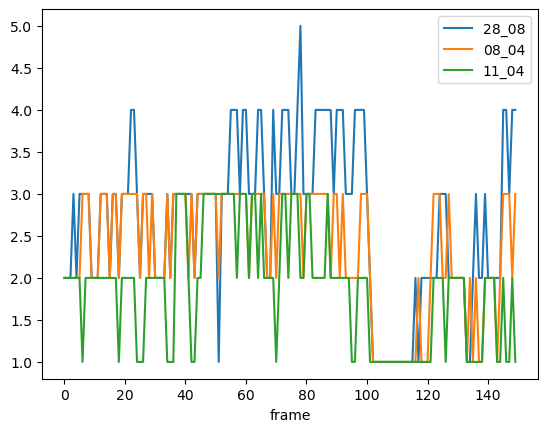

In [105]:
plt.figure(figsize=(12,6))
df_comb.plot(kind='line')

In [ ]:
preprocessed_img = preprocess(img, gaussian_kernel)
med = np.median(preprocessed_img)
ret, thresh = cv.threshold(preprocessed_img, multiplier*med, 255, cv.THRESH_BINARY)
total_edges.append(np.count_nonzero(thresh))
img_transform.append(thresh)
gray_images.append(convertgray(path + "/" + frames[i]))
plot_images2by2(img_transform[i], gray_images[i])
plt.title(str(med) + ", " + str(np.mean(preprocessed_img)))

# Merge images to video 

In [245]:
def Images2Video(image_folder, video_file_name="combine_images.mp4"):
    #image_folder = r"F:\Work\SOCAAutomation\Dataset\Images\25_04_2025"
    out = cv.VideoWriter("combine_images.mp4", cv.VideoWriter_fourcc(*"MJPG"), 1, (640, 640))
    for file in os.listdir(image_folder):
        file_path = image_folder + "/" + file
        frame = resize(cv.imread(file_path))
        out.write(frame)
    out.release()

In [ ]:
Images2Video(r"F:\Work\SOCAAutomation\Dataset\Images\25_04_2025", video_file_name="combine_images.mp4")